# Marchenko redatuming with 3D dataset - comparison of results

### Author: M.Ravasi

This notebook compares the estimated up-going and total Green's functions for different level of subsampling of reflection response

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import zarr
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt
from scipy.spatial import Voronoi, ConvexHull, voronoi_plot_2d

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.waveeqprocessing.marchenko import Marchenko as dMarchenko
from pylops_distributed.optimization.cg import cg as dcg

from utils import voronoi_volumes

## Inputs

Input files

In [2]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/Marchenko3D/"

In [3]:
inputfile_aux = os.environ["STORE_PATH"] + '3DMarchenko_auxiliary_2.npz' 

# subsampling=1
gestfile = 'GreensFunctions/gest_subsampling1.npz' 

# subsampling=2
gest2file = 'GreensFunctions/gest_subsampling2.npz' 

# subsampling=4
gest4file = 'GreensFunctions/gest_subsampling4.npz' 

# subsampling=8
gest8file = 'GreensFunctions/gest_subsampling8.npz' 

Read subsurface fields and wavelet to apply to subsurface fields

In [4]:
inputdata_aux = np.load(inputfile_aux)

# Receivers
r = inputdata_aux['recs'].T
r2 = r[:, ::2]
r4 = r[:, ::4]
r8 = r[:, ::8]

nr = r.shape[1]
nr2 = r2.shape[1]
nr4 = r4.shape[1]
nr8 = r8.shape[1]
dr = r[0,1]-r[0,0]

# Virtual points
vs = inputdata_aux['vs'] 

# Time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# Subsurface fields
Gsub = inputdata_aux['G']
G0sub = inputdata_aux['G0']
wav = ricker(t[:51], 20)[0]
wav_c = np.argmax(wav)

# Convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

Read estimates

In [5]:
gest = np.load(gestfile)
p0minus = gest['dp0_minus']
gest_minus = gest['dg_inv_minus']
gest_tot = gest['dg_inv_tot']
w = gest['w']

gest2 = np.load(gest2file)
p0minus2 = gest2['dp0_minus']
gest2_minus = gest2['dg_inv_minus']
gest2_tot = gest2['dg_inv_tot']
w2 = gest2['w']

gest4 = np.load(gest4file)
p0minus4 = gest4['dp0_minus']
gest4_minus = gest4['dg_inv_minus']
gest4_tot = gest4['dg_inv_tot']
w4 = gest4['w']

gest8 = np.load(gest8file)
p0minus84 = gest8['dp0_minus']
gest8_minus = gest8['dg_inv_minus']
gest8_tot = gest8['dg_inv_tot']
w8= gest8['w']

Visualization

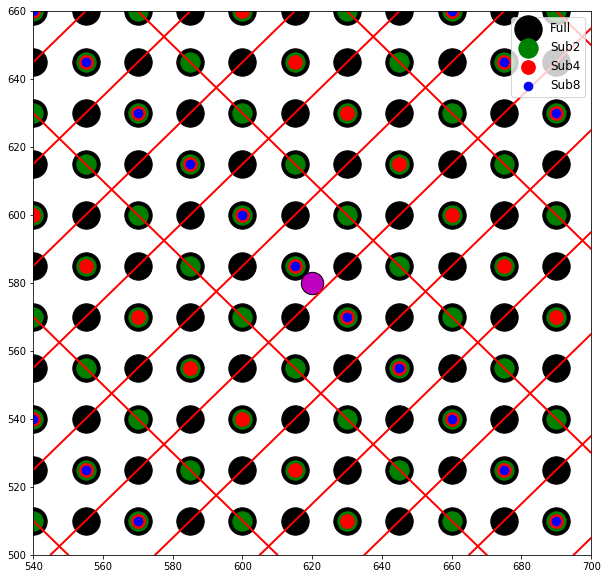

In [6]:
vertex, vols = voronoi_volumes(r[:2].T)
vertex2, vols2 = voronoi_volumes(r2[:2].T)
vertex4, vols4 = voronoi_volumes(r4[:2].T)
vertex8, vols8 = voronoi_volumes(r8[:2].T)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
"""
voronoi_plot_2d(vertex, ax=ax, show_points=False,
                show_vertices=False, line_colors='K',
                line_width=2, line_alpha=0.6, point_size=10)
voronoi_plot_2d(vertex2, ax=ax, show_points=False,
                show_vertices=False, line_colors='g',
                line_width=2, line_alpha=0.6, point_size=10)
"""
voronoi_plot_2d(vertex4, ax=ax, show_points=False,
                show_vertices=False, line_colors='r',
                line_width=2, point_size=10)
ax.scatter(r[0], r[1], marker='.', s=3000, c='k', edgecolors='k', label='Full')
ax.scatter(r2[0], r2[1], marker='.', s=1500, c='g', label='Sub2')
ax.scatter(r4[0], r4[1], marker='.', s=750, c='r', label='Sub4')
ax.scatter(r8[0], r8[1], marker='.', s=300, c='b', label='Sub8')
ax.scatter(vs[0], vs[1], marker='.', s=2000, c='m', edgecolors='k')
ax.set_xlim(vs[0]-80, vs[0]+80)
ax.set_ylim(vs[1]-80, vs[1]+80)
ax.legend(fontsize=12)
plt.savefig('Figures/geometries.eps', bbox_inches='tight')
plt.savefig('Figures/geometries.png', dpi=300, bbox_inches='tight')

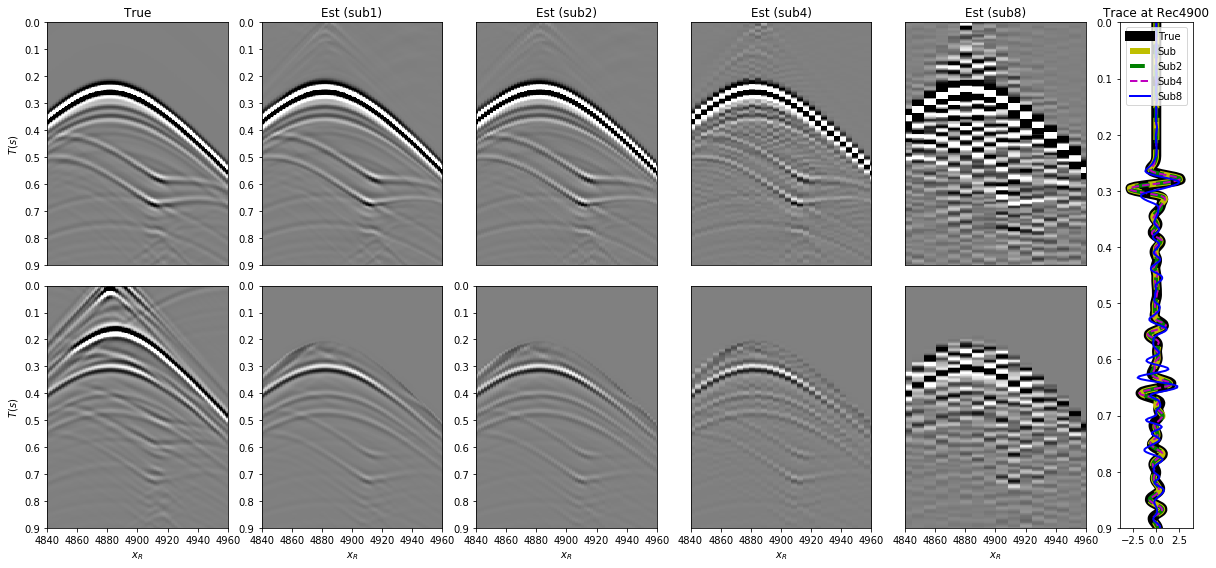

In [7]:
ymax=0.9

fig = plt.figure(figsize=(17, 8))
ax10 = plt.subplot2grid((4, 11), (0, 0), rowspan=2, colspan=2)
ax20 = plt.subplot2grid((4, 11), (2, 0), rowspan=2, colspan=2)
ax11 = plt.subplot2grid((4, 11), (0, 2), rowspan=2, colspan=2)
ax21 = plt.subplot2grid((4, 11), (2, 2), rowspan=2, colspan=2)
ax12 = plt.subplot2grid((4, 11), (0, 4), rowspan=2, colspan=2)
ax22 = plt.subplot2grid((4, 11), (2, 4), rowspan=2, colspan=2)
ax13 = plt.subplot2grid((4, 11), (0, 6), rowspan=2, colspan=2)
ax23 = plt.subplot2grid((4, 11), (2, 6), rowspan=2, colspan=2)
ax14 = plt.subplot2grid((4, 11), (0, 8), rowspan=2, colspan=2)
ax24 = plt.subplot2grid((4, 11), (2, 8), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 11), (0, 10), rowspan=4)

# Full wavefields
ax10.imshow(Gsub, cmap='gray', vmin=-2e3, vmax=2e3, extent=(0, nr, t[-1], t[0]))
ax10.set_title('True')
ax10.axis('tight')
ax10.set_ylim(ymax, 0)
ax10.set_xlim(nr//2-60, nr//2+60)
ax10.set_xticks([], [])
ax10.set_ylabel(r'$T(s)$')
ax11.imshow(gest_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax11.set_xticks([], []), ax12.set_yticks([], [])
ax11.set_title('Est (sub1)')
ax11.axis('tight')
ax11.set_ylim(ymax, 0)
ax11.set_xlim(nr//2-60, nr//2+60)
ax12.imshow(gest2_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax12.set_xticks([], []), ax12.set_yticks([], [])
ax12.set_title('Est (sub2)')
ax12.axis('tight')
ax12.set_ylim(ymax, 0)
ax12.set_xlim(nr//2-60, nr//2+60)
ax13.imshow(gest4_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax13.set_xticks([], []), ax13.set_yticks([], [])
ax13.set_title('Est (sub4)')
ax13.axis('tight')
ax13.set_ylim(ymax, 0)
ax13.set_xlim(nr//2-60, nr//2+60)
ax14.imshow(gest8_tot.T, cmap='gray', vmin=-2e3, vmax=2e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax14.set_xticks([], []), ax14.set_yticks([], [])
ax14.set_title('Est (sub8)')
ax14.axis('tight')
ax14.set_ylim(ymax, 0)
ax14.set_xlim(nr//2-60, nr//2+60)

# Upgoing wavefields
ax20.imshow(p0minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax20.axis('tight')
ax20.set_ylim(ymax, 0)
ax20.set_xlim(nr//2-60, nr//2+60)
ax20.set_xlabel(r'$x_R$')
ax20.set_ylabel(r'$T(s)$')
ax21.imshow(gest_minus.T * (1-w.T), cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax21.axis('tight')
ax21.set_ylim(ymax, 0)
ax21.set_xlim(nr//2-60, nr//2+60)
ax21.set_xlabel(r'$x_R$')
ax22.imshow(gest2_minus.T * (1-w2.T), cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax22.axis('tight')
ax22.set_ylim(ymax, 0)
ax22.set_xlim(nr//2-60, nr//2+60)
ax22.set_xlabel(r'$x_R$')
ax23.imshow(gest4_minus.T * (1-w4.T), cmap='gray', vmin=-1e3, vmax=1e3, 
            extent=(0, nr, t[-1], -t[-1]))
ax23.set_yticks([], [])
ax23.axis('tight')
ax23.set_ylim(ymax, 0)
ax23.set_xlim(nr//2-60, nr//2+60)
ax23.set_xlabel(r'$x_R$')
ax24.imshow(gest8_minus.T * (1-w8.T), cmap='gray', vmin=-1e3, vmax=1e3,
            extent=(0, nr, t[-1], -t[-1]))
ax24.set_yticks([], [])
ax24.axis('tight')
ax24.set_ylim(ymax, 0)
ax24.set_xlim(nr//2-60, nr//2+60)
ax24.set_xlabel(r'$x_R$')

# Trace
ax3.plot(np.exp(4*t) * Gsub[:, nr//2+4]/Gsub.max(), t, 'k', lw=10, label='True')
ax3.plot(np.exp(4*t) * gest_tot[nr//2+4, nt-1:]/gest_tot.max(), t, '--y', lw=6, label='Sub')
ax3.plot(np.exp(4*t) * gest2_tot[nr2//2+2, nt-1:]/gest2_tot.max(), t, '--g', lw=4, label='Sub2')
ax3.plot(np.exp(4*t) * gest4_tot[nr4//2+1, nt-1:]/gest4_tot.max(), t, '--m', lw=2, label='Sub4')
ax3.plot(np.exp(4*t) * gest8_tot[nr8//2, nt-1:]/gest8_tot.max(), t, 'b', lw=2, label='Sub8')
ax3.set_xlim(-4, 4);
ax3.set_ylim(ymax, 0);
ax3.legend(fontsize=10, loc='upper center')
ax3.set_title('Trace at Rec%d' % (nr//2))
plt.tight_layout()
plt.savefig('Figures/gest_comparsion.eps', bbox_inches='tight')
plt.savefig('Figures/gest_comparsion.png', dpi=300, bbox_inches='tight')